# ISBN Clustering

In [1]:
library(data.table)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


In [2]:
options(repr.plot.height=5)

In [4]:
db = DBI::dbConnect(RPostgreSQL::PostgreSQL(), dbname='openlib')

In [20]:
numspaces = list(work=100000000, edition=200000000, rec=300000000, isbn=900000000)

## Clustering Algorithm

We cluster ISBNs by taking the bipartite graph of ISBNs and records, and computing the closure for each ISBN.  Each closure becomes a cluster with a single ‘book’ ID.

In [5]:
Rcpp::sourceCpp("cluster.cpp")
cluster_isbns = function(isbn_rec_tbl) {
    message("initializing clusters")
    clusters = isbn_rec_tbl %>% group_by(isbn_id) %>% summarize(cluster=min(record)) %>% ungroup() %>%
        mutate(cluster = as.integer(cluster))
    message("populating edges")
    edges = isbn_rec_tbl %>%
        rename(left_isbn = isbn_id) %>%
        inner_join(isbn_rec_tbl %>% rename(right_isbn = isbn_id)) %>%
        select(left_isbn, right_isbn) %>%
        distinct()
    message("clustering ", nrow(clusters), " isbns with ", nrow(edges), " edges")
    c2 = compute_clusters(clusters, edges)
    message("built ", length(unique(c2$cluster)), " clusters")
    c2
}

## Library of Congress

In [21]:
loc_rec_isbns = db %>% tbl('loc_rec_isbn') %>% select(isbn_id, record=rec_id) %>% collect()
print(loc_rec_isbns)

# A tibble: 6,598,494 x 2
   isbn_id  record
 *   <int>   <int>
 1 1208872 9270712
 2 1905061 9270713
 3   55906 9270713
 4 3248213 9270714
 5 6350339 9270715
 6  564406 9270715
 7 1206432 9270716
 8  684237 9270717
 9 3164770 9270718
10 3004299 9270718
# ... with 6,598,484 more rows


In [22]:
loc_clusters = cluster_isbns(loc_rec_isbns)

initializing clusters
populating edges
Joining, by = "record"
clustering 6522453 isbns with 10485637 edges
[    0.00] starting iteration 1
[    1.74] iteration 1 changed 23985 memberships
[    1.74] starting iteration 2
[    3.45] iteration 2 changed 288 memberships
[    3.46] starting iteration 3
[    5.19] iteration 3 changed 2 memberships
[    5.20] starting iteration 4
[    6.91] iteration 4 changed 0 memberships
built 5185860 clusters


How big are our largest clusters?

In [23]:
cluster_sizes = loc_clusters %>% group_by(cluster) %>% summarize(nisbns=n()) %>% ungroup() 
cluster_sizes %>% arrange(-nisbns) %>% head()

cluster,nisbns
9927813,162
44464,128
7451086,123
2577188,116
6446243,98
7394785,84


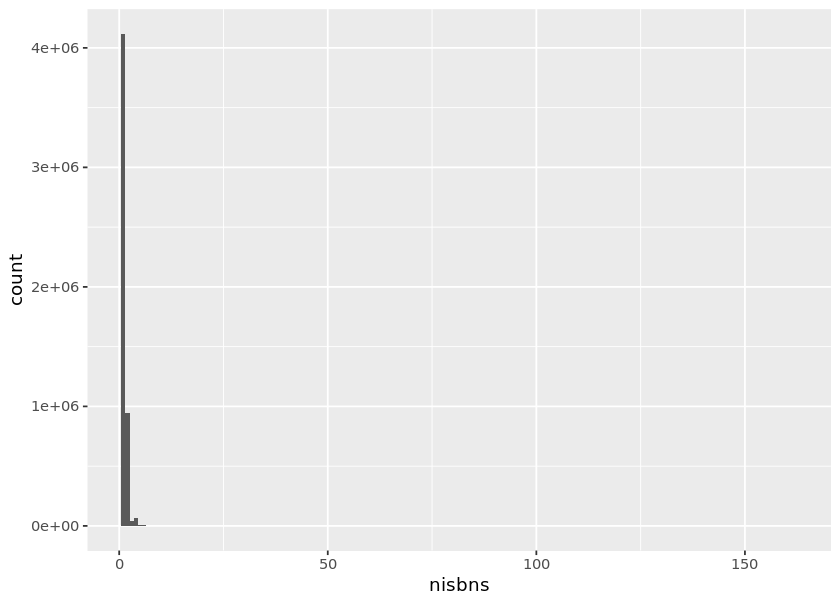

In [24]:
ggplot(cluster_sizes) +
    aes(x=nisbns) +
    geom_histogram(binwidth=1)

In [34]:
loc_clusters %>% select(isbn_id, cluster) %>% write_csv('data/loc-clusters.csv', col_names = FALSE)

## OpenLibrary

In [12]:
ol_rec_edges = db %>% tbl('ol_isbn_link') %>% select(isbn_id, record=book_code) %>% 
    collect()

In [13]:
print(ol_rec_edges)

# A tibble: 20,952,388 x 2
    isbn_id    record
 *    <int>     <int>
 1  9496692 104639583
 2 18948890 114945908
 3 17231899 107645957
 4  1458705 116226665
 5 15093692 105217942
 6 14312993 109315235
 7 12671033 110656498
 8 13787054 109698248
 9  1657041 108963121
10  3001220 103934755
# ... with 20,952,378 more rows


In [14]:
ol_clusters = cluster_isbns(ol_rec_edges)

initializing clusters
populating edges
Joining, by = "record"
clustering 18310061 isbns with 205738181 edges
[    0.00] starting iteration 1
[   32.88] iteration 1 changed 1194546 memberships
[   32.88] starting iteration 2
[   63.05] iteration 2 changed 60532 memberships
[   63.06] starting iteration 3
[   93.05] iteration 3 changed 6172 memberships
[   93.05] starting iteration 4
[  122.64] iteration 4 changed 1246 memberships
[  122.65] starting iteration 5
[  151.93] iteration 5 changed 86 memberships
[  151.94] starting iteration 6
[  181.60] iteration 6 changed 13 memberships
[  181.61] starting iteration 7
[  211.51] iteration 7 changed 0 memberships
built 9754781 clusters


In [15]:
ol_cluster_sizes = ol_clusters %>% group_by(cluster) %>% summarize(nisbns=n()) %>% ungroup() 
ol_cluster_sizes %>% arrange(-nisbns) %>% head()

cluster,nisbns
105077683,7520
100339351,6518
100004153,5161
107956464,4276
106611855,2820
100058368,2109


In [16]:
ol_cluster_sizes = ol_cluster_sizes %>% mutate(bucket = as.integer(log10(nisbns)))
ol_cluster_buckets = ol_cluster_sizes %>% filter(nisbns > 1) %>% group_by(bucket) %>% summarize(n=n())
ol_cluster_buckets

bucket,n
0,5882132
1,48810
2,395
3,12


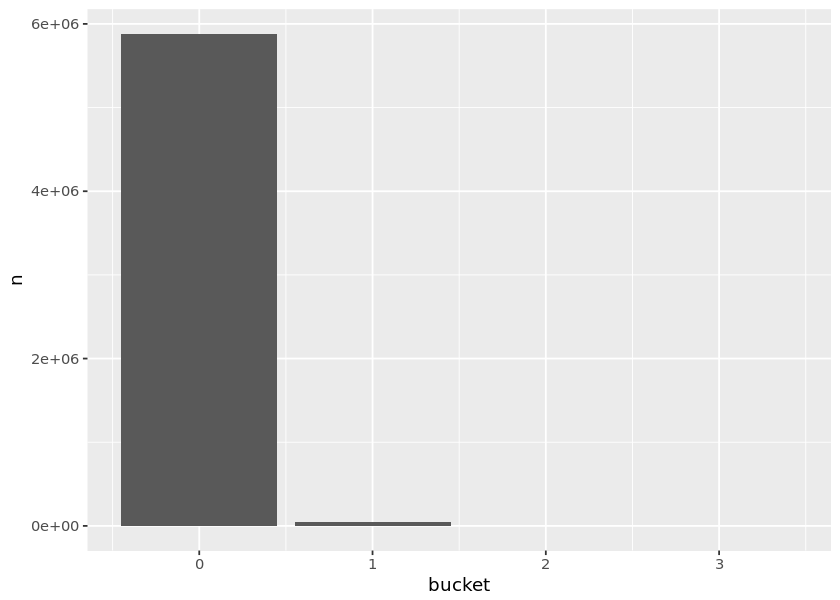

In [17]:
ggplot(ol_cluster_buckets) +
    aes(x=bucket, y=n) +
    geom_bar(stat='identity')

In [33]:
ol_clusters %>% select(isbn_id, cluster) %>% write_csv('data/ol-clusters.csv', col_names = FALSE)

## Integrated Clusters

In [37]:
all_isbn_recs = bind_rows(
    loc_rec_isbns %>% mutate(record = record + numspaces$rec),
    ol_rec_edges
)

In [38]:
print(all_isbn_recs)

# A tibble: 27,550,882 x 2
   isbn_id    record
     <int>     <dbl>
 1 1208872 309270712
 2 1905061 309270713
 3   55906 309270713
 4 3248213 309270714
 5 6350339 309270715
 6  564406 309270715
 7 1206432 309270716
 8  684237 309270717
 9 3164770 309270718
10 3004299 309270718
# ... with 27,550,872 more rows


In [39]:
int_clusters = cluster_isbns(all_isbn_recs)

initializing clusters
populating edges
Joining, by = "record"
clustering 19192081 isbns with 207995923 edges
[    0.00] starting iteration 1
[   30.49] iteration 1 changed 1429312 memberships
[   30.50] starting iteration 2
[   59.02] iteration 2 changed 53994 memberships
[   59.02] starting iteration 3
[   87.93] iteration 3 changed 5916 memberships
[   87.94] starting iteration 4
[  116.86] iteration 4 changed 1209 memberships
[  116.87] starting iteration 5
[  145.45] iteration 5 changed 104 memberships
[  145.45] starting iteration 6
[  174.62] iteration 6 changed 7 memberships
[  174.63] starting iteration 7
[  203.32] iteration 7 changed 5 memberships
[  203.33] starting iteration 8
[  232.13] iteration 8 changed 0 memberships
built 10261127 clusters


In [40]:
int_cluster_sizes = int_clusters %>% group_by(cluster) %>% summarize(nisbns=n()) %>% ungroup() 
int_cluster_sizes %>% arrange(-nisbns) %>% head()

cluster,nisbns
105077683,7520
100339351,6518
100004153,5169
107956464,4276
106611855,2820
100058368,2126


In [41]:
int_cluster_sizes = int_cluster_sizes %>% mutate(bucket = as.integer(log10(nisbns)))
int_cluster_buckets = int_cluster_sizes %>% filter(nisbns > 1) %>% group_by(bucket) %>% summarize(n=n())
int_cluster_buckets

bucket,n
0,6102059
1,50761
2,406
3,12


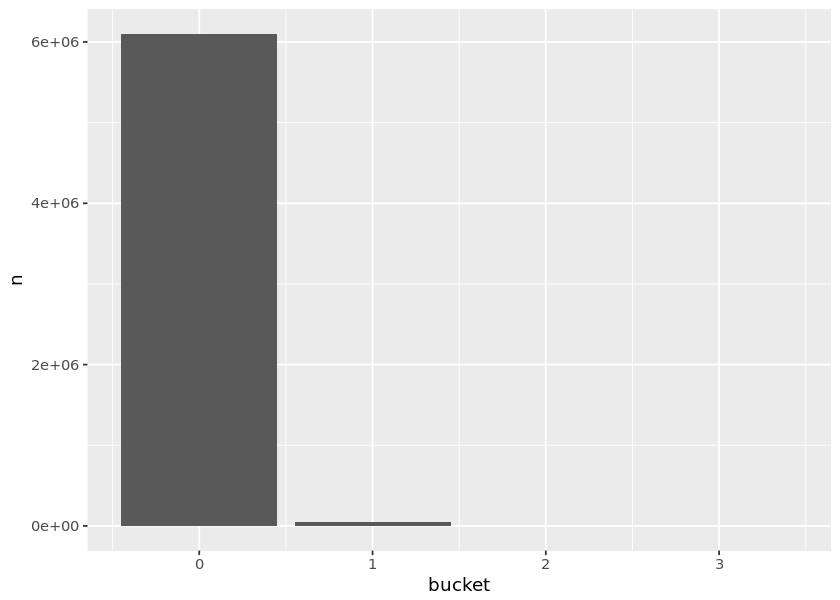

In [42]:
ggplot(int_cluster_buckets) +
    aes(x=bucket, y=n) +
    geom_bar(stat='identity')

In [43]:
int_clusters %>% select(isbn_id, cluster) %>% write_csv('data/isbn-clusters.csv', col_names=FALSE)

### Load ISBN info to work on checking clusters

In [35]:
isbn_ids = db %>% tbl('isbn_id') %>% collect()
print(isbn_ids)

# A tibble: 20,485,242 x 2
   isbn_id isbn         
 *   <int> <chr>        
 1       1 1878005340   
 2       2 0813372720   
 3       3 0160416205   
 4       4 3927480118   
 5       5 8185867712   
 6       6 3789016853   
 7       7 156071056X   
 8       8 1410449025   
 9       9 9781847424280
10      10 8477852146   
# ... with 20,485,232 more rows


How many ISBNs are in LOC but not OL?

In [36]:
missing_isbns = loc_clusters %>% anti_join(select(ol_clusters, isbn_id))
nrow(missing_isbns)

Joining, by = "isbn_id"


[1] 882020